In [1]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import helper_func
import math
import models
import scipy.special as sp
from scipy.misc import logsumexp
import gc

In [2]:
full_X,x,test_mask = helper_func.load_data()
dataset = 'movielens' ## name of folder/dataset
metric = 'mae'
users = x1.shape[0]
items1 = x1.shape[1]
items2 = x2.shape[2]
train_non_zero_indices1 = helper_func.non_zero_entries(x1)
train_non_zero_indices2 = helper_func.non_zero_entries(x2)
score = []

In [3]:
epochs = 30000
epochs += 1
test_every = 1000
no_samples = 5000
k = 10
param1 = models.invgauss_response();  # 'ztp' or 'normal'
param2 = models.invgauss_response();

In [4]:
varpi = 0.1 #looks like 'w^bar' or omega bar
sparsity = 1.0 - float(len(train_non_zero_indices))/(users*items)
em = -np.log(sparsity)
emsq = np.sqrt(em/k)
varrho = 0.1 # looks like mirror inverted q
eta = varrho * emsq  #looks like n
rho =  varrho * varrho  #looks like p
zeta = varpi *emsq #looks like mirror inverted c
omega = varpi * varpi #looks like w
xi = 0.7
tau = 10000.0
cutoff_loglik = np.log(1e-6);
n_trunc = 20;

In [5]:
t_user = np.ones(shape=users)*tau
t_item1 = np.ones(shape=items1)*tau
t_item2 = np.ones(shape=items2)*tau

a_s = np.ones(shape=[users,k])*eta
bs = np.ones(shape=[users,k])*varrho
ar =  np.ones(shape=users)*(rho+k*eta)   # not fixed in the original code
br = np.ones(shape=users)*(rho/varrho)

av1 = np.ones(shape=[items1,k])*zeta
bv1 = np.ones(shape=[items1,k])*varpi
aw1 = np.ones(shape=items1)*(omega+k*zeta)  # not fixed in the original code
bw1 = np.ones(shape=items1)*(omega/varpi)
varphi1 = np.zeros([users,items1,k])

av2 = np.ones(shape=[items2,k])*zeta
bv2 = np.ones(shape=[items2,k])*varpi
aw2 = np.ones(shape=items2)*(omega+k*zeta)  # not fixed in the original code
bw2 = np.ones(shape=items2)*(omega/varpi)
varphi2 = np.zeros([users,items2,k])

In [6]:
# curr_loglik = cutoff_loglik -1.0

# while cutoff_loglik > curr_loglik:
#     n_trunc -= 1
#     curr_loglik = n_trunc* np.log(em) - np.log(np.expm1(em)) - math.lgamma(n_trunc + 1);
# n_trunc += 1
# print n_trunc

In [7]:
param1.mle_update(train_non_zero_indices1,x1,no_samples)
param2.mle_update(train_non_zero_indices2,x2,no_samples)

In [8]:
print param1.get_param()
print param2.get_param()

(3.5030000000000001, 18.28251522455621)


In [9]:
curr_iter  = 0
while curr_iter <= epochs:
    curr_iter += 1
    u = np.random.randint(low=0,high=users,dtype='int64')
    i1 = np.random.randint(low=0,high=items1,dtype='int64')
    i2 = np.random.randint(low=0,high=items2,dtype='int64')
    tu = np.power(t_user[u],-xi)
    ti1 = np.power(t_item1[i1],-xi)
    ti2 = np.power(t_item2[i2],-xi)
    
    br[u] = (1.0-tu)*br[u] + tu*(rho/varrho + np.sum(a_s[u,:]/bs[u,:]))
    bs[u,:] = (1.0-tu)*bs[u,:] + tu*(ar[u]/br[u] + items*(av[i,:]/bv[i,:]))
    bw[i] = (1.0-ti)*bw[i] + ti*(omega/varpi + np.sum(av[i,:]/bv[i,:]))
    bv[i,:] = (1.0-tu)*bv[i,:] + ti*(aw[i]/bw[i] + users*(a_s[u,:]/bs[u,:]))
    
    if x[u,i]==0:
        a_s[u,:] = (1.0-tu)*a_s[u,:] + tu*eta
        av[i,:] = (1.0-ti)*av[i,:] + ti*zeta
    else:
        A_ui = np.sum((a_s[u,:]*av[i,:])/(bs[u,:]*bv[i,:]))
        en = param.expectation(x[u,i],A_ui,n_trunc)
        varphi[u,i,:]= sp.digamma(a_s[u,:])-np.log(bs[u,:])+sp.digamma(av[i,:])-np.log(bv[i,:])
        log_norm = logsumexp(varphi[u,i,:])
        varphi[u,i,:] = np.exp(varphi[u,i,:]-log_norm)
        a_s[u,:] = (1.0-tu)*a_s[u,:] + tu*(eta+items*en*varphi[u,i,:])
        av[i,:] = (1.0-ti)*av[i,:] + ti*(zeta+users*en*varphi[u,i,:])
    
    t_user[u] += 1
    t_item[i] += 1
    
    if curr_iter%test_every == 0:
        print curr_iter
        score.append(helper_func.check(a_s,bs,av,bv,test_mask,full_X,metric=metric))
        gc.collect()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


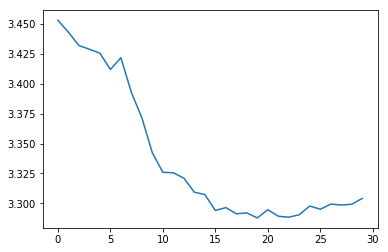

In [10]:
plt.plot(score)
plt.show()
#np.savetxt('../results/'+dataset+'/'+'hcpf_po_'+metric+'_'+str(k)+'.txt',np.array(score))
